# CA684: Machine Learning Assignment - Predicting Video Memorability

**Problem description:** This task focuses on the problem of predicting how memorable a video is to viewers. It requires participants to automatically predict memorability scores for videos that reflect the   probability   a   video   will   be   remembered.   Task   participants   are   provided   with   an extensive dataset of videos that are accompanied by memorability annotations, as well as pre-extracted   state-of-the-art   visual   features.   The   ground   truth   has   been   collected through   recognition   tests,   and   thus   results   from   objective   measurement   of memory performance.   Participants   will   be   required   to   train   computational   models   capable   of inferring video memorability from visual content. Descriptive titles (Captions) attached to the   videos   may  not  be   used.   Models   will   be   evaluated   through   standard   evaluation metrics used in ranking tasks (Spearman’s rank correlation).

Reference: [MediaEval](http://www.multimediaeval.org)
<a id='contact_details'></a>

# Notebook Index

This notebook is organized as follows:

* **SECTION 1 &nbsp;  :** [Function Definitions](#section1)


* **SECTION 2 &nbsp;  :** [Loading Features](#section2)


* **SECTION 3 &nbsp;  :** [Data Preprocessing](#section3)


* **SECTION 4 &nbsp;  :** [Experiments with different Machine Learning models and features/combinations](#section4)
  * Section 4.1: [Random Forest with C3D](#section4.1)
  * Section 4.2: [SVR with C3D](#section4.2)
  * Section 4.3: [Random Forest with HMP](#section4.3)
  * Section 4.4: [SVR with HMP](#section4.4)
  * Section 4.5: [Random Forest with C3D and HMP](#section4.5)
  * Section 4.6: [SVR with C3D and HMP](#section4.6)
  
  
* **SECTION 5 &nbsp;  :** [Selecting the best model with features](#section5)


* **SECTION 6 &nbsp;  :** [Predicting the Memorability scores on Test-Set](#section6)
  * Section 6.1:  [Training full 6000 Dev-Set](#section6.1)
  * Section 6.2:  [Importing Test Datasets and Captions](#section6.2)
  * Section 6.3:  [Merging C3D and HMP Features](#section6.3)
  * Section 6.4:  [Predicting the Scores and Exporting the Results](#section6.4)

<font color='blue'>* Click on the links to jump directly to desired sections *</font>

#### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import glob
import nltk

<a id='section1'></a>

## SECTION 1&nbsp;:  FUNCTIONS DEFINITION

Loading definitions for C3D and HMP features and function to calculate Spearman's Coefficient.

In [2]:
#Function to load C3D features
def load_c3d(captions, c3dPath):
    files = list(captions["video"].values)
    c3d_features = []
    for file in files:
        file = c3dPath+file[:-4]+'txt'
        c3d_features.append(np.loadtxt(file))
    return c3d_features

In [3]:
#Function to load HMP features
def load_hmp(captions, hmp_path):
    files = list(captions["video"].values)
    hmp_features = []
    for file in files:
        file = hmp_path+file[:-4]+'txt'
        with open(file) as f:
            for line in f:
                pairs=line.split()
                HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
                HMP = np.zeros(6075)
            for idx in HMP_temp.keys():
                HMP[idx-1] = HMP_temp[idx]
            hmp_features.append(HMP)
    return hmp_features

In [4]:
#Function to load the captions into dataframes
def load_captions(filename):
    video_name = []
    captions = []
    dataframe = pd.DataFrame()
    with open(filename) as file:
        for line in file:
            pair = line.split() #each line in the text file contains to words so, this code will split them into two words
            video_name.append(pair[0]) #first word will be assigned as video name
            captions.append(pair[1]) #second word will be assigned as caption
        dataframe['video']=video_name #setting these two as column names of dataframe
        dataframe['caption']=captions
    return dataframe

In [5]:
#Function to calculate Spearman coefficient scores
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

<a id='section2'></a>

## SECTION 2&nbsp;:  LOADING FEATURES

<font color='red'> *NOTE:* </font>&nbsp; The complete datset and features were downloaded to my local machine. So, the path is local to my system.

In [6]:
#load the ground truth dataset
csv_path ='ground-truth.csv'
dataset = pd.read_csv(csv_path)
dataset.head(5)

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


In [7]:
#load captions
captions_path ='dev-set_video-captions.txt'
captions = load_captions(captions_path)
captions.head(5)

,video,caption
0,video3.webm,blonde-woman-is-massaged-tilt-down
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,khr-gangsters
3,video8.webm,medical-helicopter-hovers-at-airport
4,video10.webm,couple-relaxing-on-picnic-crane-shot


In [8]:
captions_path ='dev-set_video-captions.txt'
captions = load_captions(captions_path)
captions.head(5)
#load C3D features
c3dPath = 'C3D/'
c3d_features = load_c3d(captions,c3dPath)
print(c3d_features[:10])

[array([2.0249420e-02, 1.5778000e-03, 8.2625000e-04, 9.4509000e-04,
       6.2790000e-05, 3.4900000e-06, 1.1618200e-03, 9.7420000e-05,
       2.1790000e-05, 1.0330000e-05, 3.3725000e-04, 6.3631000e-04,
       1.1117000e-04, 1.0078200e-03, 3.6100000e-06, 6.3123000e-04,
       3.9050000e-05, 4.0980000e-05, 9.1250000e-05, 3.0321000e-04,
       1.5410000e-05, 3.1970000e-05, 5.2210000e-05, 6.1550000e-05,
       1.7464590e-02, 6.6581000e-04, 6.5270000e-05, 5.4450000e-05,
       2.7318000e-04, 1.3858800e-03, 3.3300000e-06, 1.3557900e-03,
       5.1650000e-04, 2.4261200e-03, 2.7191400e-03, 2.7700000e-06,
       1.5570800e-03, 2.4923000e-04, 2.6324300e-03, 9.3050000e-05,
       8.9018000e-04, 9.8830000e-05, 1.0030000e-05, 2.2525000e-04,
       9.7030000e-05, 3.3656300e-03, 7.9170000e-05, 2.3487000e-04,
       5.0306000e-04, 7.2603369e-01, 1.9330000e-05, 1.3091000e-04,
       9.6670000e-05, 1.3184000e-04, 3.4292000e-04, 4.9308000e-04,
       9.7340000e-05, 1.0900000e-06, 3.7808000e-04, 7.9463700

In [9]:
#load HMP features
hmp_path = 'HMP/'
hmp_features = load_hmp(captions,hmp_path)
print(hmp_features[:10])

[array([1.25563e-01, 2.40360e-02, 3.14000e-04, ..., 8.60000e-05,
       5.80000e-04, 0.00000e+00]), array([7.526e-03, 1.421e-03, 6.800e-05, ..., 2.200e-04, 7.620e-04,
       1.224e-03]), array([1.09584e-01, 1.89780e-02, 2.89000e-04, ..., 5.20000e-05,
       2.58000e-04, 2.15000e-04]), array([0.120431, 0.013561, 0.000277, ..., 0.000588, 0.000503, 0.000452]), array([5.026e-03, 1.356e-03, 5.500e-05, ..., 6.320e-04, 1.128e-03,
       6.400e-05]), array([0.003342, 0.001333, 0.000144, ..., 0.000462, 0.000698, 0.00021 ]), array([1.498e-03, 4.490e-04, 1.100e-05, ..., 3.000e-04, 6.790e-04,
       5.000e-05]), array([9.714e-03, 1.985e-03, 4.600e-05, ..., 1.930e-04, 4.320e-04,
       3.140e-04]), array([4.466e-03, 9.130e-04, 9.000e-06, ..., 1.190e-04, 1.150e-04,
       3.500e-05]), array([8.967e-03, 1.683e-03, 3.800e-05, ..., 8.000e-05, 1.940e-04,
       5.800e-05])]


In [10]:
dataset.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


In [11]:
captions.head()

,video,caption
0,video3.webm,blonde-woman-is-massaged-tilt-down
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,khr-gangsters
3,video8.webm,medical-helicopter-hovers-at-airport
4,video10.webm,couple-relaxing-on-picnic-crane-shot


In [12]:
#shape of the dataframes
print(f'Ground Truth : {dataset.shape}')
print(f'C3D          : ({len(c3d_features)})')
print(f'HMP          : ({len(hmp_features)})')

Ground Truth : (6000, 5)
C3D          : (6000)
HMP          : (6000)


***
<a id='section3'></a>

## SECTION 3: DATA PREPROCESSING

### We have loaded both Development set Captions and Test set Captions in two seperate variables. I will be combining both of these to a single variable and implement CountVectorizer.

The reaseon behind this is, initially both were seperately vectorized and later we faced dimensions issues when trying to predict the test set scores.

For training I will be using only first 6000 captions by splitting and rest 2000 will be used for prediction.

**Combining features C3D and HMP**

In [13]:
c3d_hmp = c3d_features
counter = 0
for item in range(6000):
    c3d_hmp[counter] = np.append(c3d_hmp[counter],hmp_features[counter],axis=0)
    counter = counter+1

In [14]:
print(len(c3d_hmp), len(c3d_hmp[0]))

6000 6176


Now we have the following features

    1. C3D in: c3dfeatures 
    2. HMP in: hmp_features
    3. C3D and HMP in: c3d_hmp

***
<a id='section4'></a>

## SECTION 4: &nbsp; EXPERIMEMTS WITH DIFFERENT MACHINE LEARNING MODELS AND FEATURES/COMBINATIONS <a id='section4.1'></a>

### Section 4.1: &nbsp; Random Forest with C3D

In [15]:
X = c3d_features
y = dataset[['short-term_memorability','long-term_memorability']].values

In [16]:
# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [17]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=20,random_state=42,verbose=2)

In [18]:
rf_regressor.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.9s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 12.5min finished


RandomForestRegressor(n_estimators=20, random_state=42, verbose=2)

In [19]:
rf_pred = rf_regressor.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


In [20]:
rf_regressor

RandomForestRegressor(n_estimators=20, random_state=42, verbose=2)

In [21]:
Get_score(rf_pred, y_test)

The Spearman's correlation coefficient is: 0.275
The Spearman's correlation coefficient is: 0.104


***
<a id='section4.5'></a>

### Section 4.2: &nbsp;  SVR with C3D

In [22]:
svr_X = c3d_features
svr_y_short = dataset[['short-term_memorability']].values
svr_y_long = dataset[['long-term_memorability']].values

In [23]:
# Splitting the dataset into the Training set and Test set
short_X_train,short_X_test,short_y_train,short_y_test = train_test_split(svr_X,svr_y_short,test_size=0.2,random_state=40)
long_X_train,long_X_test,long_y_train,long_y_test = train_test_split(svr_X,svr_y_long,test_size=0.2,random_state=40)

In [24]:
from sklearn.preprocessing import StandardScaler
short_X = StandardScaler()
short_y = StandardScaler()
short_X_train = short_X.fit_transform(short_X_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_X_train = long_X.fit_transform(long_X_train)
long_y_train = long_y.fit_transform(long_y_train)

In [25]:
from sklearn.svm import SVR
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_X_train, short_y_train)
long_regressor.fit(long_X_train,long_y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVR()

In [26]:
short_pred = short_regressor.predict(short_X_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_X_test)
long_pred = long_y.inverse_transform(long_pred)

In [27]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.206
The Spearman's correlation coefficient is: 0.117


***
<a id='section4.5'></a>

### Section 4.3: &nbsp; Random Forest with HMP

In [29]:
X = hmp_features
y = dataset[['short-term_memorability','long-term_memorability']].values

In [30]:
# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [31]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=20,random_state=42,verbose=2)

In [32]:
rf_regressor.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.7s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 12.5min finished


RandomForestRegressor(n_estimators=20, random_state=42, verbose=2)

In [33]:
rf_pred = rf_regressor.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


In [34]:
rf_regressor

RandomForestRegressor(n_estimators=20, random_state=42, verbose=2)

In [35]:
Get_score(rf_pred, y_test)

The Spearman's correlation coefficient is: 0.233
The Spearman's correlation coefficient is: 0.103


### Section 4.4: &nbsp; SVR with HMP

In [36]:
svr_X = hmp_features
svr_y_short = dataset[['short-term_memorability']].values
svr_y_long = dataset[['long-term_memorability']].values

In [37]:
# Splitting the dataset into the Training set and Test set
short_X_train,short_X_test,short_y_train,short_y_test = train_test_split(svr_X,svr_y_short,test_size=0.2,random_state=40)
long_X_train,long_X_test,long_y_train,long_y_test = train_test_split(svr_X,svr_y_long,test_size=0.2,random_state=40)

In [38]:
from sklearn.preprocessing import StandardScaler
short_X = StandardScaler()
short_y = StandardScaler()
short_X_train = short_X.fit_transform(short_X_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_X_train = long_X.fit_transform(long_X_train)
long_y_train = long_y.fit_transform(long_y_train)

In [39]:
from sklearn.svm import SVR
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_X_train, short_y_train)
long_regressor.fit(long_X_train,long_y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVR()

In [40]:
short_pred = short_regressor.predict(short_X_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_X_test)
long_pred = long_y.inverse_transform(long_pred)

In [41]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.190
The Spearman's correlation coefficient is: 0.084


### Section 4.5: &nbsp; Random Forest with C3D and HMP

In [42]:
X = c3d_hmp
y = dataset[['short-term_memorability','long-term_memorability']].values

In [43]:
# Splitting the dataset into the Training set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [44]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100,random_state=45,verbose=2)

In [45]:
rf_regressor.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.0s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 22.6min finished


RandomForestRegressor(random_state=45, verbose=2)

In [46]:
rf_pred = rf_regressor.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [47]:
Get_score(rf_pred, y_test)

The Spearman's correlation coefficient is: 0.330
The Spearman's correlation coefficient is: 0.130


***
<a id='section4.8'></a>

### Section 4.6: &nbsp; SVR with C3D and HMP

In [48]:
svr_X = c3d_hmp
svr_y_short = dataset[['short-term_memorability']].values
svr_y_long = dataset[['long-term_memorability']].values

In [49]:
# Splitting the dataset into the Training set and Test set
short_X_train,short_X_test,short_y_train,short_y_test = train_test_split(svr_X,svr_y_short,test_size=0.2,random_state=40)
long_X_train,long_X_test,long_y_train,long_y_test = train_test_split(svr_X,svr_y_long,test_size=0.2,random_state=40)

In [50]:
from sklearn.preprocessing import StandardScaler
short_X = StandardScaler()
short_y = StandardScaler()
short_X_train = short_X.fit_transform(short_X_train)
short_y_train = short_y.fit_transform(short_y_train)
long_X = StandardScaler()
long_y = StandardScaler()
long_X_train = long_X.fit_transform(long_X_train)
long_y_train = long_y.fit_transform(long_y_train)

In [51]:
from sklearn.svm import SVR
short_regressor = SVR(kernel = 'rbf')
long_regressor = SVR(kernel = 'rbf')
short_regressor.fit(short_X_train, short_y_train)
long_regressor.fit(long_X_train,long_y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVR()

In [52]:
short_pred = short_regressor.predict(short_X_test)
short_pred = short_y.inverse_transform(short_pred)
long_pred = long_regressor.predict(long_X_test)
long_pred = long_y.inverse_transform(long_pred)

In [53]:
Get_score(short_pred, short_y_test)
Get_score(long_pred, long_y_test)

The Spearman's correlation coefficient is: 0.206
The Spearman's correlation coefficient is: 0.117


***
<a id='section5'></a>

# SECTION 5:  SELECTING THE BEST MODEL WITH FEATURES

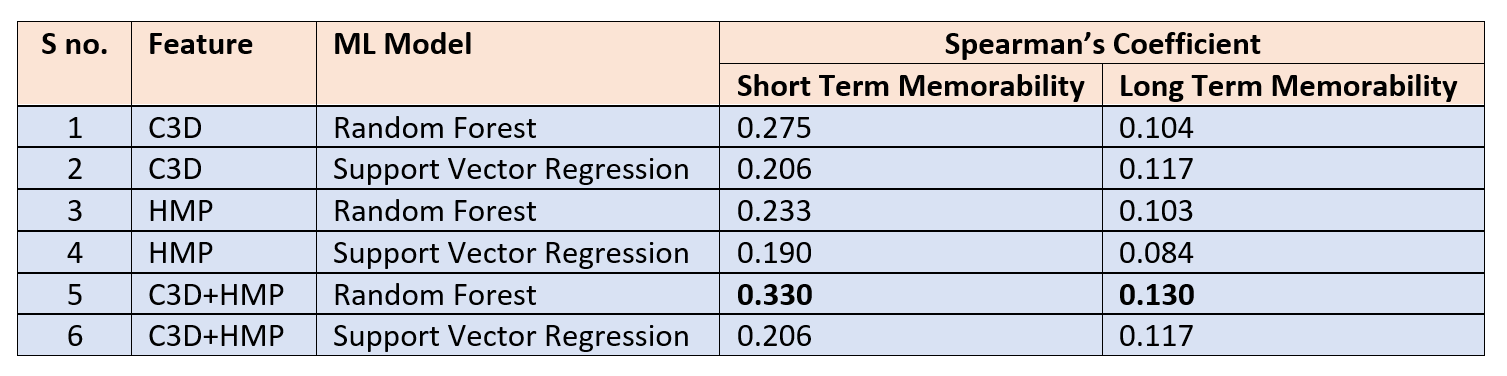

In [56]:
from IPython.display import Image
Image(filename="table.png",width="500",height="300")

Above table shows the Spearman's coefficient corelation scores obtained with different features/combinations. 

From the results, It is notable that C3D and HMP together yielded the best performance with Random Forest model

***
<a id='section7'></a>

# SECTION 6: &nbsp; PREDICTING THE TEST RESULTS

In the above [Random Forest with C3D and HMP](#section4.5) model, our development dataset is split into training and testing. In order to predict the test results, we need to train our model using full 6000 development dataset. 

In the Below lines of code, we will be using full 6000 records of development datatset to train our model and predict the scores on testing set which has 2000 records.
<a id='section7.1'></a>

### Section 6.1: &nbsp; Training full 6000 Dev-Set

In [57]:
X = c3d_hmp 
y = dataset[['short-term_memorability','long-term_memorability']].values

In [58]:
len(y)

6000

In [59]:
print(f'X: ({len(X)})')
print(f'y:{y.shape}')

X: (6000)
y:(6000, 2)


In [60]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100,random_state=45)

In [61]:
rf_regressor.fit(X,y)

RandomForestRegressor(random_state=45)

Now We have trained our model for full 6000 Dev-set.
<a id='section7.2'></a>

<a id='section7.2'></a>

### Section 6.2: &nbsp; Importing Test Dataset

In [62]:
#importing test Dataset
csv_path = 'test/ground_truth_template.csv'
test_dataset = pd.read_csv(csv_path)
test_dataset.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


In [63]:
#importing and loading the test set captions
test_captions_path ='test/test-set-1_video-captions.txt'
test_captions = load_captions(test_captions_path)
test_captions.head()

,video,caption
0,video7494.webm,green-jeep-struggling-to-drive-over-huge-rocks
1,video7495.webm,hiking-woman-tourist-is-walking-forward-in-mou...
2,video7496.webm,close-up-of-african-american-doctors-hands-usi...
3,video7497.webm,slow-motion-of-a-man-using-treadmill-in-the-gy...
4,video7498.webm,slow-motion-of-photographer-in-national-park


In [64]:
#importing and loading the test set captions
c3d_test_path = 'test/C3D_test/'
test_c3dfeatures = load_c3d(test_captions,c3d_test_path)
print(test_c3dfeatures[:2])

[array([1.3576000e-04, 2.1330000e-04, 1.2475900e-03, 1.1490000e-05,
       1.1800000e-06, 4.2760000e-05, 5.8000000e-07, 5.8200000e-06,
       6.6100000e-06, 6.9870000e-05, 9.7200000e-06, 7.9060000e-05,
       7.1007133e-01, 1.9511000e-04, 9.4000000e-07, 1.7330000e-05,
       5.0290000e-05, 2.5410000e-05, 3.1720000e-05, 1.4000000e-07,
       5.0000000e-08, 4.6035860e-02, 1.2000000e-07, 6.2300000e-06,
       4.0490000e-05, 4.7900000e-06, 8.1149600e-03, 2.6500000e-06,
       7.5000000e-07, 1.8500000e-06, 1.6500000e-06, 4.3200000e-05,
       1.7860000e-05, 2.1622000e-03, 6.1530000e-05, 1.7700000e-06,
       8.7700000e-06, 5.4800000e-06, 1.6684000e-04, 7.0000000e-08,
       3.3744000e-04, 3.4600000e-06, 8.5000000e-07, 1.9000000e-07,
       2.3700000e-06, 2.1300000e-06, 1.7400000e-06, 5.1000000e-07,
       2.3197800e-03, 6.3077000e-04, 7.1900000e-06, 1.4596000e-04,
       2.4134400e-03, 3.7820000e-05, 2.1790000e-05, 3.2000000e-06,
       1.9200000e-06, 1.3000000e-07, 7.2440000e-05, 6.2030000

In [65]:
hmp_test_path = 'test/HMP_test/'
#load C3D features
#load HMP features
test_hmp_features = load_hmp(test_captions,hmp_test_path)
print(test_hmp_features[:2])

[array([2.2039e-02, 5.2640e-03, 9.8000e-05, ..., 1.6500e-04, 4.8800e-04,
       1.8700e-04]), array([4.694e-03, 1.934e-03, 4.000e-05, ..., 1.090e-04, 1.360e-04,
       2.900e-05])]


### Section 6.3: &nbsp; Merging C3D and HMP features

In [66]:
test_dataset.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


We need to predict and fill the values of the above Short-term Memorability and Long-term Memorability Scores using our trained model

In [67]:
print(len(test_c3dfeatures), len(test_c3dfeatures[0]))

2000 101


In [68]:
print(len(test_hmp_features), len(test_hmp_features[0]))

2000 6075


In [69]:
print(len(hmp_features), len(hmp_features[0]))

6000 6075


In [71]:
print(len(c3d_features), len(c3d_features[0]))

6000 6176


In [73]:
test_c3d_hmp = test_c3dfeatures
counter = 0
for item in range(2000):
    test_c3d_hmp[counter] = np.append(test_c3d_hmp[counter],test_hmp_features[counter],axis=0)
    counter = counter+1

In [72]:
print(len(c3d_hmp), len(c3d_hmp[0]))

6000 6176


In [74]:
print(len(test_c3d_hmp), len(test_c3d_hmp[0]))

2000 6176


***
<a id='section7.3'></a>

### Section 6.4: &nbsp; Predicting the scores and Exporting the Results

In [75]:
test_pred = rf_regressor.predict(c3d_hmp)

In [76]:
print(test_pred)

[[0.9002  0.82448]
 [0.89814 0.70645]
 [0.86009 0.70307]
 ...
 [0.75065 0.78368]
 [0.92539 0.92846]
 [0.90686 0.67692]]


In [77]:
print(test_c3d_hmp)

[array([0.00013576, 0.0002133 , 0.00124759, ..., 0.000165  , 0.000488  ,
       0.000187  ]), array([1.265900e-04, 2.377000e-05, 4.950115e-02, ..., 1.090000e-04,
       1.360000e-04, 2.900000e-05]), array([4.8898152e-01, 5.8536000e-04, 2.4540000e-05, ..., 9.2000000e-05,
       1.4300000e-04, 5.1000000e-05]), array([2.4925078e-01, 1.0176300e-03, 8.0200000e-06, ..., 2.7900000e-04,
       4.7000000e-04, 2.1900000e-04]), array([9.89415e-03, 3.41300e-05, 2.61261e-03, ..., 2.28000e-04,
       3.34000e-04, 8.60000e-05]), array([1.16551e-03, 7.72500e-05, 1.16095e-03, ..., 2.61000e-04,
       5.15000e-04, 2.70000e-05]), array([1.187860e-02, 1.570998e-02, 1.966100e-04, ..., 2.160000e-04,
       3.640000e-04, 7.500000e-05]), array([0.00034891, 0.00206028, 0.00148048, ..., 0.000373  , 0.000995  ,
       0.001268  ]), array([4.49788e-02, 1.41564e-03, 6.01100e-05, ..., 2.75000e-04,
       1.56800e-03, 5.50000e-04]), array([2.7783221e-01, 7.6147000e-04, 2.5034000e-04, ..., 1.7000000e-05,
       2.800

In [78]:
test_pred = rf_regressor.predict(test_c3d_hmp)

In [79]:
type(test_c3d_hmp)

list

In [81]:
pred = pd.DataFrame()

In [82]:
type(test_pred)

numpy.ndarray

In [83]:
pred['short-term'] = test_pred[:,0]

In [84]:
pred['long-term'] = test_pred[:,1]

In [85]:
pred.head()

,short-term,long-term
0,0.87133,0.78366
1,0.84505,0.78415
2,0.87404,0.78041
3,0.88518,0.82188
4,0.81719,0.76944


In [86]:
pred.describe()

,short-term,long-term
count,2000.000000,2000.000000
mean,0.858446,0.775490
std,0.024130,0.033666
min,0.774550,0.591040
25%,0.840700,0.754687
50%,0.860485,0.777865
75%,0.878440,0.799373
max,0.907620,0.879650


In [87]:
pred.to_csv("Divya_Aren_20210762_Predictions.csv",index=False)    

***